In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.all import (
    DiagramBuilder,
    MeshcatVisualizer,
    Simulator,
    StartMeshcat,
)
from helper import (
    CartMultiPendulumSystem,
    CartMultiPendulumWorld2Joint,
    CartMultiPendulumStabalizingLqrController,
)

In [3]:
meshcat = StartMeshcat()
meshcat.Set2dRenderMode(xmin=-5, xmax=5, ymin=-3.1, ymax=3.1)

INFO:drake:Meshcat listening for connections at http://localhost:7000


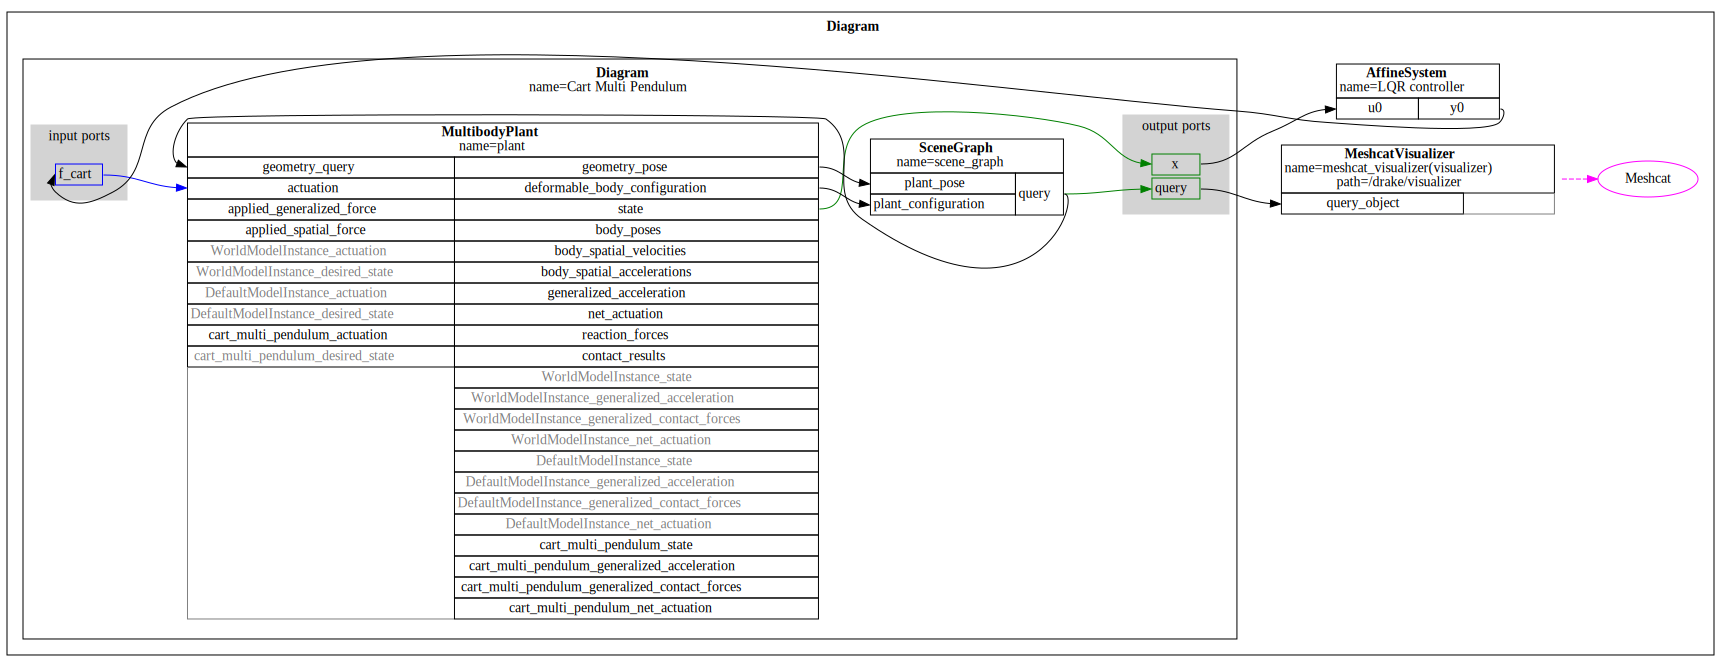

In [4]:
cart_multi_pendulum = CartMultiPendulumSystem(m1=1,l1=1, m2=1,l2=1, m3=1,l3=1)

configuration = ['up', 'up', 'up']

Q = np.diag([10, 10, 10, 10, 1, 1, 1, 1])
R = np.diag([1])
controller = CartMultiPendulumStabalizingLqrController(cart_multi_pendulum, configuration, Q, R)

builder = DiagramBuilder()
builder.AddNamedSystem("Cart Multi Pendulum", cart_multi_pendulum)
builder.AddNamedSystem("LQR controller", controller)

builder.Connect(cart_multi_pendulum.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), cart_multi_pendulum.get_input_port(0))

visualizer = MeshcatVisualizer.AddToBuilder(builder, cart_multi_pendulum.get_output_port(1), meshcat)

diagram = builder.Build()

display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

In [6]:
simulator = Simulator(diagram)

x0_world = [3, np.deg2rad(180), np.deg2rad(180), np.deg2rad(180), 0, 0, 0, 0]
x0 = CartMultiPendulumWorld2Joint(len(x0_world)) @ np.array(x0_world)
context = simulator.get_mutable_context()
context.SetTime(0.0)
context.SetContinuousState(x0)

simulator.Initialize()

visualizer.StartRecording(False)
simulator.AdvanceTo(10)
visualizer.PublishRecording()